# Определение возраста покупателей  

Автор: Семен Лимонов.  

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача: Построить модель, которая по фотографии определит приблизительный возраст человека на основе набора фотографий людей с указанием возраста.

Целевое значение метрики MAE на тестовой выборке - не более 8.

Описание данных:  

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. Набор данных состоит из одной папки со всеми изображениями `(/final_files)` и CSV-файла `labels.csv` с двумя колонками:   

`file_name` — имя файла с изображением,  
`real_age` — реальный возраст человека на фотографии.  

Планируемые этапы:

1. Загрузка данных, исследовательский анализ набора фотографий.
2. Подготовка данных к обучению, обучение нейронной сети и рассчет целевой метрики качества.  
3. Анализ обученной модели. 

## Исследовательский анализ данных

In [1]:
# Импортируем необходимые бибилиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# загрузим данные из файлов
# создадим датафрейм с данными о возрасте и именами файлов
labels = pd.read_csv('/datasets/faces/labels.csv')

# загрузим фото с помощью динамического загрузчика 
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# выведем общучю информацию о наборе
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Набор данных состоит из 7591 изображений, которых может быть не достаточно при обучении нейронной сети для точных предсказаний, т.к. количество параметров в нейронных сетях гораздо больше, поэтому может понадобиться увеличение количества изображений с помощью аугментации.

In [4]:
# выведем первые 5 строк
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Набор  состоит из 7591 названий файлов фотографий и меток с возрастом. Пропуски отсутствуют, наименования столбцов соответствуют snake_case. Типы данных в столбцах соответствуют содержанию.

In [5]:
# выведем на экран информацию об одном из тензоров c информацией о фотографиях
features, target = next(gen_flow)

print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


Четырехмерный тензор, полученный с помощью динамического загрузчика, состоит из 32 фотографий размером 224х224 с 3 цветовыми каналами.

In [6]:
# выведем общую информацию о распределении возраста
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Среднее значение возраста 31 год, медиана - 29 лет. Присутствуют фото людей с возрастом от 1 до 100 лет. Половину набора представляет возрастная категория 20 - 41 год.

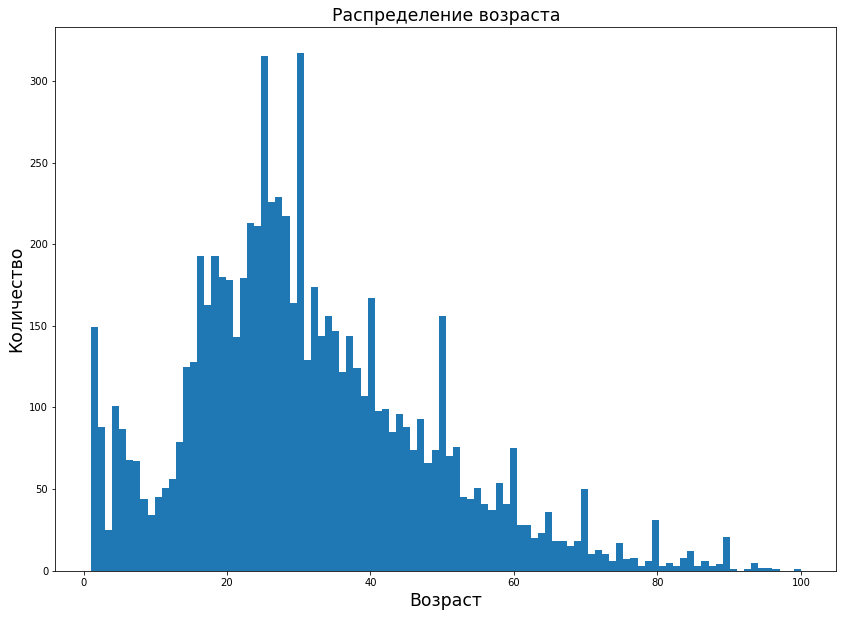

In [7]:
# построим диаграмму распределения возраста
plt.figure(figsize=(14,10))
plt.title('Распределение возраста', fontdict={'fontsize': 'xx-large'})
plt.xlabel('Возраст', fontdict={'fontsize': 'xx-large'})
plt.ylabel('Количество', fontdict={'fontsize': 'xx-large'})
plt.hist(data=labels, x='real_age', bins=100)
plt.show()

Наблюдается заметное количество фото детей возрастом от 1 до 7 лет. При этом, количество подростков от 8 до 12 лет заметно меньше. Основная масса фотографий сосредоточена в возрастном диапазоне 14 - 50 лет, с акцентом на возрасте 22-30 лет. Фотографий людей старше 50 лет значительно меньше.  

Ярко выражены пики около юбилейных возрастов - 25, 30, 40, 50, 60, 70, 80, 90. Данный перекос может говорить о неточности разметки из-за человеческого фактора. Возможно, в отсутствие точных данных разметчики склонны округлять возраст определяя его субъективно.  

Неточности разметки, а также неравномерное распределение фотографий по возрастным категориям, в том числе недостаток фото в диапазоне 12 - 15, будет увеличивать ошибку модели в процессе предсказания, особенно в диапазоне 12-22, что важно для решения второй поставленной задачи.

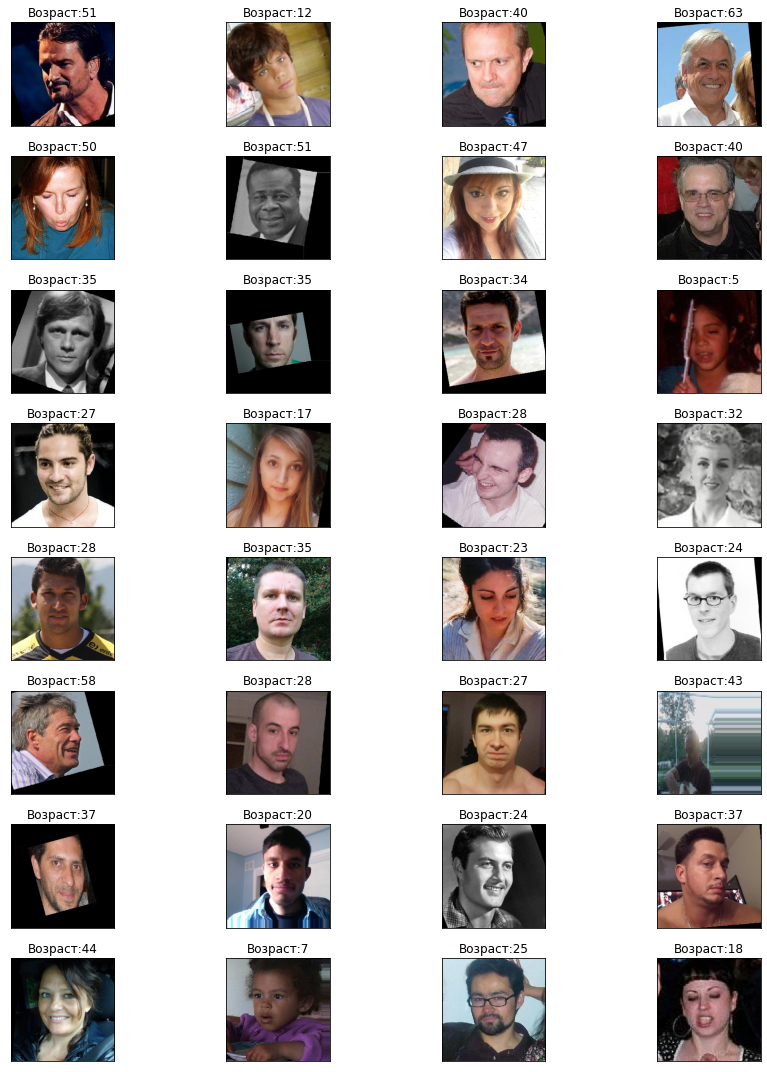

In [8]:
# выведем 32 изображения с меткой возраста на экран для визуальной оценки
features, target = next(gen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(32):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(features[i])
 
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Возраст:{target[i]}')
    plt.tight_layout()

Вывод: набор данных состоит из цветных и черно-белых фотографий лиц людей в различной обстановке и с разных ракурсов. Встречаются искаженные фотографии, с артефактами, посторонними предметами, а также в полный рост.

Возраст из целевого признака субъективно соответствует возрасту людей, изображенных на фотографиях.  

Учитывая не слишком высокое качество и не полную однородность изображений, для снижения ошибки модели может использоваться увеличение выборки в процессе обучения модели методом аугментации (зеркальные отражения, сдвиг фото в вертикальном и горизонтальном направлении). 

## Обучение модели

Загрузим и обучим сверточную нейросеть ResNet50 для обработки изображений и решения задачи регрессии (прогнозирования возраста). Для снижения ошибки модели применим аугментацию изображений в процессе создания обучающей выборки (горизонтальное отражение, сдвиг вертикально и горизонтально на 20%). Обучение будем производить на 15 эпохах.

```python
import pandas as pd
import numpy as np
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# функция загрузки обучающей выборки размером 75% от набора
def load_train(path):
    # создадим датафрейм с именами файлов и метками возраста
    labels = pd.read_csv(path + 'labels.csv')
    # применим аугментацию в процессе загрузки - горизонтальное отражение, сдвиг вертикально и горизонтально на 20%,
    # нормируем значения яркости пикселей к диапазону 0 - 1, разделив значения на 255
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

# функция загрузки тестовой выборки размером 25% от набора
def load_test(path):
    # создадим датафрейм с именами файлов и метками возраста
    labels = pd.read_csv(path + 'labels.csv')
    # нормируем значения яркости пикселей к диапазону 0 - 1, разделив значения на 255
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow

# функция создания модели ResNet50
def create_model(input_shape):
    #создадим модель ResNet50 без выходного слоя
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # добавим выходной слой с 1 нейроном для получения предсказания возраста с
    # функцией активации ReLu, которая отсечет отрицательные значения 
    # и оставит неизменными положительные значения возраста
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.00005)
    # для ускорения обучения укажем метрику потерь - MSE, целевую - MAE
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

# функция обучения модели ResNet50
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Результат обучения модели:
```
Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 123s - loss: 303.8217 - mae: 12.6783 - val_loss: 856.4323 - val_mae: 24.3892
Epoch 2/15
178/178 - 104s - loss: 92.9833 - mae: 7.2685 - val_loss: 953.4232 - val_mae: 26.1025
Epoch 3/15
178/178 - 104s - loss: 70.0520 - mae: 6.3966 - val_loss: 643.0833 - val_mae: 20.0154
Epoch 4/15
178/178 - 101s - loss: 55.1362 - mae: 5.7086 - val_loss: 128.4032 - val_mae: 8.4806
Epoch 5/15
178/178 - 104s - loss: 46.4189 - mae: 5.2319 - val_loss: 85.6709 - val_mae: 6.9127
Epoch 6/15
178/178 - 104s - loss: 40.5896 - mae: 4.8880 - val_loss: 76.0312 - val_mae: 6.5785
Epoch 7/15
178/178 - 103s - loss: 35.7713 - mae: 4.5997 - val_loss: 75.5525 - val_mae: 6.3209
Epoch 8/15
178/178 - 102s - loss: 33.1404 - mae: 4.4590 - val_loss: 91.8847 - val_mae: 7.2412
Epoch 9/15
178/178 - 103s - loss: 28.6176 - mae: 4.1339 - val_loss: 68.2475 - val_mae: 6.1231
Epoch 10/15
178/178 - 96s - loss: 26.0077 - mae: 3.9487 - val_loss: 95.3904 - val_mae: 7.2745
Epoch 11/15
178/178 - 88s - loss: 24.2850 - mae: 3.8163 - val_loss: 70.0307 - val_mae: 6.0726
Epoch 12/15
178/178 - 93s - loss: 22.2672 - mae: 3.6485 - val_loss: 64.6650 - val_mae: 6.0792
Epoch 13/15
178/178 - 94s - loss: 20.1218 - mae: 3.4814 - val_loss: 70.1288 - val_mae: 6.2188
Epoch 14/15
178/178 - 103s - loss: 17.3349 - mae: 3.2226 - val_loss: 64.6719 - val_mae: 5.9888
Epoch 15/15
178/178 - 101s - loss: 16.8535 - mae: 3.2005 - val_loss: 63.3060 - val_mae: 6.0317
60/60 - 11s - loss: 63.3060 - mae: 6.0317
Test MAE: 6.0317
```

## Анализ обученной модели

При создании нейросети ResNet50 были использованы следующие параметры:
- костяк сети (backbone) - ResNet50, с предобученными весами, загруженными с сервера, без верхнего слоя;
- отдельно созданные верхние слои:
    - GlobalAveragePooling2D() - пулинг с окном во весь тензор;
    - Dense() - полносвязный выходной слой с 1 нейроном для регрессии, с функцией активации ReLu, которая отсечет отрицательные значения и оставит неизменными положительные значения возраста;
- для снижения ошибки модели применена аугментация изображений в обучающей выборке (горизонтальное отражение, сдвиг вертикально и горизонтально на 20%);
- использованы метрика потерь - mean_squared_error, метрика качества - mean_average_error;
- размер батча - 32, оптимизатор - Adam (шаг градиентного спуска - 0,00005), без заморозки весов backbone, обучение произведено на 15 эпохах.

При обучении модель уже на 5 эпохе продемонстрировала целевую метрику MAE (6.9) ниже целевого уровня (8). После финальной 15-й эпохи метрика качества MAE достигла значения 6.0. Переобучения модели не наблюдалось. 

Эксперименты показали, что аугментация дополнительно способствовала снижению метрики с 7.0 до 6.0.  

Таким образом, используемая модель при определении возраста покупателя ошибается в среднем на 6 лет, что позволяет использовать ее для решения одной из поставленных задач - рекомендации товаров, которые могут быть интересны определенным возрастным категориям.

Однако, использование только данной модели для решения второй задачи (контроль соблюдения кассирами законодательства об ограничении продажи алкоголя несовершеннолетним) не рекомендуется по причине высокого риска получения штрафа в случае ошибки модели в большую сторону при опеределении возраста покупателя. Для решения данной задачи необходимо применять дополнительные меры контроля совместно с данной моделью.